In [1]:
import os

import xarray as xr
import numpy as np
import pandas as pd

import sys
sys.path.append('..')
from scripts.globals import COLORS as colors
from scripts.globals import where_to_find_data
import scripts.preprocessing as proc
import scripts.plot_utils as plot
from scripts.estimate_utils import *
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.patheffects as pe
from matplotlib.lines import Line2D
from cartopy.feature import OCEAN, RIVERS

In [2]:
bathy_path = '../../data/processed/bathymetry.nc'

In [3]:
def plot_occupation(ax, path, idx, vmin, vmax, ref_depth=-1500):

    data = xr.open_dataarray(f"{path}/box_{idx}.nc")
    counts = data.sum(dim = ['time'])
    total_count = len(data)
    bathy = xr.open_dataarray(bathy_path).sel(longitude = data.longitude, latitude = data.latitude)


    c = ax.contourf(counts.longitude, counts.latitude, counts / total_count * 100, cmap = "binary", 
                        vmin = vmin, vmax = vmax, levels = np.arange(vmin, vmax, 0.25), extend = "max")
    
    ax.contour(bathy.longitude, bathy.latitude, bathy, [ref_depth], 
                colors = "red", linestyles = "solid", linewidths = .6)

    return c, ax

def pacific_occupation(ax, vmin, vmax, path, compute_func, ref_depth=-1500):
    ax.set_xlim(-135, -60)

    colors = ['#1b9e77', '#d95f02', '#7570b3']

    colormap = {i : color for i, color in zip(range(len(colors)), colors)}

    regions = proc.read_region_input_files('../sensitivity_test_years/pacific/10years/regions.input')
        
    groups = proc.obtain_boxes_grouping(regions)
    boxes = [box for boxes in regions.values() for box in boxes]

    text_offsets = {}
    for i in range(1, len(boxes) + 1):
        if i in [3, 4]:
            text_offsets[i] = [0, -7.5]
        elif i in [5, 6]:
            text_offsets[i] = [0, 7.5]
        else:
            text_offsets[i] = [7.5, 0]

    for i, group in enumerate(groups):
        
        for idx in group:

            box = boxes[idx - 1]

            ax = plot.plot_boxes(ax, box, colormap[i], idx, text_offsets[idx][0], text_offsets[idx][1])
            _, ax = compute_func(ax,f'../sensitivity_test_years/pacific/10years/outputs/{path}/', idx, vmin, vmax)

    ax.set_title("(a) Eastern Pacific boundary", fontsize = 15)

    handles = [mpatches.Patch(color=color, label = label) for color, label in zip(colormap.values(), regions.keys())] + \
            [Line2D([0], [0], color="red", label = f"Reference depth = {ref_depth} m")]

    ax.legend(handles=handles,
            loc = "lower left")


def atlantic_occupation(ax, vmin, vmax, path, compute_func, ref_depth=-1500):

    ax.set_xlim(-35, 40)
    ax.set_ylim(-60, 60)

    ax.add_feature(RIVERS)

    colors = ['#e7298a', '#66a61e', '#e6ab02']
    colormap = {i : color for i, color in zip(range(len(colors)), colors)}

    regions = proc.read_region_input_files('../sensitivity_test_years/atlantic/10years/regions.input')
        
    groups = proc.obtain_boxes_grouping(regions)
    boxes = [box for boxes in regions.values() for box in boxes]

    text_offsets = {}
    for i in range(1, len(boxes) + 1):
        if i in [4]:
            text_offsets[i] = [0, -7.5]
        elif i in [5]:
            text_offsets[i] = [0, 7.5]
        else:
            text_offsets[i] = [7.5, 0]

    for i, group in enumerate(groups):
        
        for idx in group:

            box = boxes[idx - 1]

            ax = plot.plot_boxes(ax, box, colormap[i], idx, text_offsets[idx][0], text_offsets[idx][1])
            c, ax = compute_func(ax, f'../sensitivity_test_years/atlantic/10years/outputs/{path}/', idx, vmin, vmax)

    ax.set_title("(b) Eastern Atlantic boundary", fontsize = 15)

    handles = [mpatches.Patch(color=color, label = label) for color, label in zip(colormap.values(), regions.keys())] + \
            [Line2D([0], [0], color="red", label = f"Reference depth = {ref_depth} m")]

    ax.legend(handles=handles,
            loc = "lower right", )

    return c

In [4]:
path = where_to_find_data('pacific')[1500]
pac_regions = proc.read_region_input_files(os.path.join(path, 'regions.input'))
pac_boxes_groups =  {n : v for n,v in zip(pac_regions.keys(), proc.obtain_boxes_grouping(pac_regions))}

path = where_to_find_data('atlantic')[1500]
atl_regions = proc.read_region_input_files(os.path.join(path, 'regions.input'))
atl_boxes_groups = {n : v for n,v in zip(atl_regions.keys(), proc.obtain_boxes_grouping(atl_regions))}

In [5]:
def plot_transport_by_depth(transports, ax, color, title, errs = False, type = 'plot'):
    vals = [np.mean(trends) for trends in transports.values()]
    depths = list(transports.keys())
    ax.grid()
    ax.set_xticks(depths)
    #ax.errorbar(depths, vals, yerr = errs, capsize = 5, color = color, marker = 'o')
    if type == 'plot':
        ax.plot(depths, vals, color = color, marker = 'o', label = title)
    elif type == 'bar':
        errs = [np.std(trends.values) for trends in transports.values()]
        ax.bar(depths, vals, color = color, width = 100, alpha = 0.2
               )
        ax.errorbar(depths, vals, yerr = errs, color = color, capsize = 10, fmt = 'o', label = title)
    ax.set_title(title)
    #ax.set_xlabel('Reference depth [m]')
    return ax


def big_plot(ax, total_transport, title = '', legend = True, mean_total = False, bbox_to_anchor = (0.5, -0.2), fontsize = 12):

    regions = total_transport.keys()

    for region, transports in total_transport.items():
        ax = plot_transport_by_depth(transports, ax, color = colors[region], title = region)

    if mean_total:
        total_series = {ref_depth : 
                        np.mean([total_transport[region][ref_depth] for region in regions], axis = 0)
                        for ref_depth in transports.keys()}
    else:
        total_series = {ref_depth : sum([total_transport[region][ref_depth] for region in regions]) for ref_depth in transports.keys()}
        
    ax = plot_transport_by_depth(total_series, ax,  color = 'black', title = 'Entire EBUS', type = 'bar' if not mean_total else 'plot', errs = False)
    ax.tick_params(axis='both', which='major', labelsize=12)
    if legend:
        ax.legend(bbox_to_anchor=bbox_to_anchor, loc = 'center', fontsize = fontsize)
    ax.set_xlabel('Reference depth [m]', fontsize = 15)
    ax.set_title(title, fontsize = 15)
    ax.grid()


def compute_transport_dictionary(name, type = 'export_timeseries', mode = 'per_region'):
    paths = where_to_find_data(name)

    regions = proc.read_region_input_files(os.path.join('../configs', f'{name}_regions.input'))
    boxes_groups = proc.obtain_boxes_grouping(regions)

    total_transport = {}

    for region, box_idx in zip(regions.keys(), boxes_groups):

        transports = {}

        for ref_depth, path in paths.items():


            timeseries = compute_carbon_per_region(box_idx, os.path.join(path, 'outputs',  type))


            transport = compute_transport(timeseries)

            transports[ref_depth] = transport

        total_transport[region] = transports
        #total_transport = {ref_depth : sum([total_transport[region][ref_depth] for region in regions.keys()]) for ref_depth in paths.keys()}
    return total_transport
        

def plot_export(group, ax, path):
    transports = []
    cols = []

    for n, l in group.items():
        for b in l: 
            ts = load_carbon_data(os.path.join(path, 'outputs/export_timeseries', f'box_{b}.nc'))
            transport = compute_transport(ts, period = 'year')
            transports.append(transport)
            cols.append(colors[n])

    transports = np.array(transports)
    transports_mean = transports.mean(axis = 1).flatten()
    transports_std = transports.std(axis = 1).flatten()

    ax.barh(y = np.arange(0, len(transports_mean))[::-1] + 1, width = transports_mean, 
            edgecolor = "black", color = cols, xerr = transports_std)

    ax.set_ylabel("Region code", fontsize = 15)
    ax.set_yticks(np.arange(0,len(transports_mean))[::-1] + 1
                  , labels = np.arange(0,len(transports_mean)) + 1)

    return ax

In [6]:
pac_transport = compute_transport_dictionary('pacific')
atl_transport = compute_transport_dictionary('atlantic')

In [7]:
offshelf_pac_transport = compute_transport_dictionary('pacific', 'off_shelf_timeseries')
offshelf_atl_transport = compute_transport_dictionary('atlantic', 'off_shelf_timeseries')

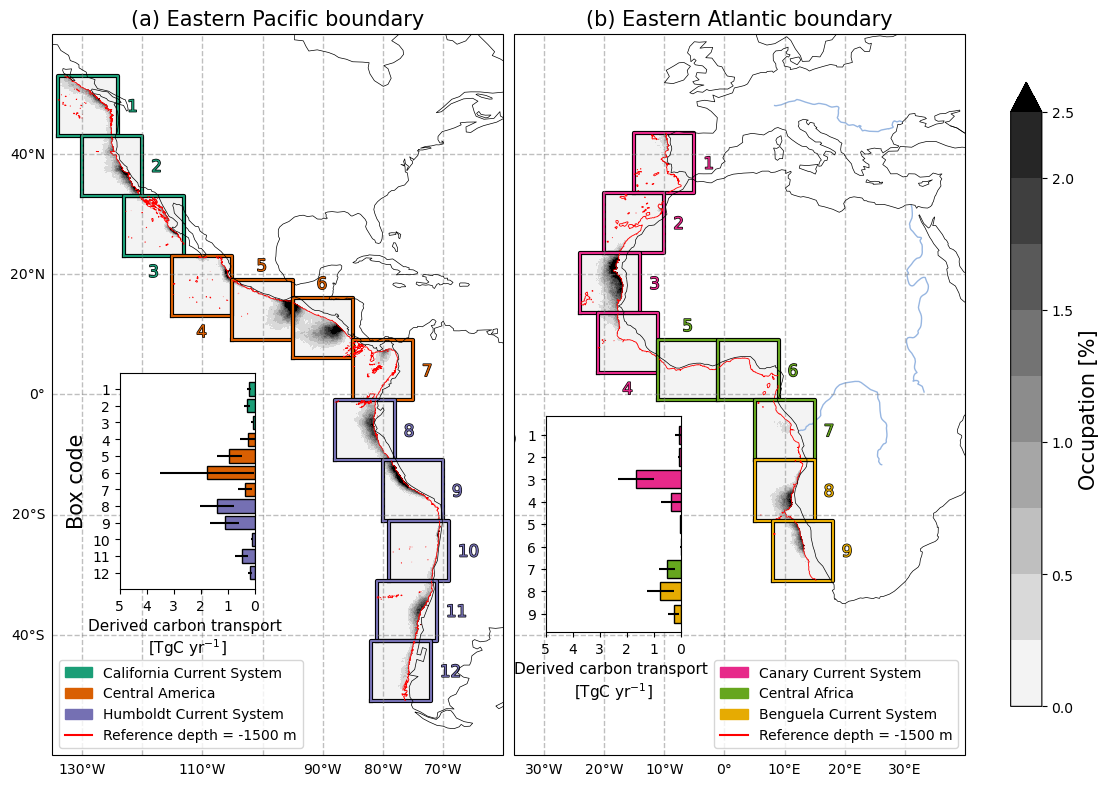

In [10]:
fig, ax = plot.set_plot(ncols = 2, figsize = [11,9])

ax[0].tick_params(labelsize = 15)
ax[1].tick_params(labelsize = 15)
ax[1].set_ylim(-80, 80)
ax[0].sharey(ax[1])

vmin = 0
vmax = 2.5

x_ticks = np.arange(0, 6, 1)


ref_depth = -1500

pacific_occupation(ax[0], vmin, vmax, 'filament_masks', plot_occupation)
c = atlantic_occupation(ax[1], vmin, vmax, 'filament_masks', plot_occupation)

cb = plt.colorbar(c, ax = ax, shrink = 0.7)
cb.set_label("Occupation [%]", fontsize = 15)
cb.ax.set_yticks(np.arange(0,  3, 0.5))

ins_size = [0.15,0.23,0.3,0.3]
ins_pac = ax[0].inset_axes(ins_size)

ins_pac = plot_export(pac_boxes_groups, ins_pac, where_to_find_data('pacific')[1500])
ins_pac.set_xlim([0, 5])
ins_pac.set_ylabel('Box code')
ins_pac.invert_xaxis()
ins_pac.set_xticks(x_ticks)
ins_pac.set_xlabel('Derived carbon transport \n[TgC yr$^{-1}$]', fontsize = 11)

ins_size = [0.07,0.17,0.3,0.3]
ins_atl = ax[1].inset_axes(ins_size)

ins_atl = plot_export(atl_boxes_groups, ins_atl, where_to_find_data('atlantic')[1500])
ins_atl.set_xlim([0, 5])
ins_atl.set_ylabel('')
ins_atl.invert_xaxis()
ins_atl.set_xticks(x_ticks)
ins_atl.set_xlabel('Derived carbon transport \n[TgC yr$^{-1}$]', fontsize = 11)
plt.savefig('images/figure_2_occupation_map.png', bbox_inches = 'tight')

In [13]:
def compute_percentage_transport(filaments, offshelf):
    percentages = {}

    for region in offshelf.keys():
        pct_by_depth = {}
        for ref_depth in [250,500,1000,1500,2000]:
            fil = filaments[region][ref_depth]
            tot = offshelf[region][ref_depth]

            pct_by_depth[ref_depth] = fil / tot * 100
        percentages[region] = pct_by_depth

    return percentages

In [14]:
pac_percentages = compute_percentage_transport(pac_transport, offshelf_pac_transport)
atl_percentages = compute_percentage_transport(atl_transport, offshelf_atl_transport)

In [15]:
for region in pac_percentages.keys():
    print(f'#### {region} ####')
    for depth in pac_transport[region].keys():
        print(f'\tDepth = {depth} m')
        total = offshelf_pac_transport[region][depth].values
        filament = pac_transport[region][depth].values
        pct = pac_percentages[region][depth].values
        # print(f'\t\t1) {total.mean().round(1)} ± {total.std().round(1)}')
        # print(f'\t\t2) {filament.mean().round(1)} ± {filament.std().round(1)}')
        # print(f'\t\t3) {pct.mean().round(1)} ± {pct.std().round(1)}')
        print(f'1) {total.mean().round(1)} ± {total.std().round(1)}')
        print(f'2) {filament.mean().round(1)} ± {filament.std().round(1)}')
        print(f'3) {pct.mean().round(1)} ± {pct.std().round(1)}')

print(f'#### Total ####')
for depth in pac_transport[region].keys():
    all_ebus_total = np.sum([offshelf_pac_transport[reg][depth].values for reg in pac_transport.keys()], axis = 0)
    all_ebus_filament = np.sum([pac_transport[reg][depth].values for reg in pac_transport.keys()], axis = 0)
    all_ebus_pct = np.mean([pac_percentages[reg][depth].values for reg in pac_transport.keys()], axis = 0)
    print(f'Depth = {depth} m')
    print(f'1) {all_ebus_total.mean().round(1)} ± {all_ebus_total.std().round(1)}')
    print(f'2) {all_ebus_filament.mean().round(1)} ± {all_ebus_filament.std().round(1)}')
    print(f'3) {all_ebus_pct.mean().round(1)} ± {all_ebus_pct.std().round(1)}')

        

#### California Current System ####
	Depth = 250 m
1) 5.9 ± 0.5
2) 0.8 ± 0.2
3) 13.8 ± 2.5
	Depth = 500 m
1) 5.6 ± 0.5
2) 0.7 ± 0.2
3) 12.7 ± 2.4
	Depth = 1000 m
1) 5.2 ± 0.5
2) 0.6 ± 0.2
3) 11.9 ± 2.4
	Depth = 1500 m
1) 4.8 ± 0.5
2) 0.5 ± 0.1
3) 11.2 ± 2.4
	Depth = 2000 m
1) 3.7 ± 0.5
2) 0.5 ± 0.1
3) 13.5 ± 2.9
#### Central America ####
	Depth = 250 m
1) 12.1 ± 2.3
2) 2.9 ± 1.9
3) 22.5 ± 10.6
	Depth = 500 m
1) 11.9 ± 2.3
2) 2.8 ± 1.9
3) 22.4 ± 10.7
	Depth = 1000 m
1) 11.6 ± 2.2
2) 2.8 ± 1.9
3) 22.3 ± 11.0
	Depth = 1500 m
1) 11.4 ± 2.2
2) 2.7 ± 1.9
3) 22.2 ± 11.2
	Depth = 2000 m
1) 11.1 ± 2.2
2) 2.6 ± 1.9
3) 22.2 ± 11.5
#### Humboldt Current System ####
	Depth = 250 m
1) 13.0 ± 1.4
2) 3.5 ± 1.0
3) 26.6 ± 5.3
	Depth = 500 m
1) 12.5 ± 1.4
2) 3.3 ± 1.0
3) 25.8 ± 5.3
	Depth = 1000 m
1) 11.8 ± 1.3
2) 3.0 ± 0.9
3) 25.1 ± 5.3
	Depth = 1500 m
1) 11.2 ± 1.2
2) 2.7 ± 0.8
3) 24.1 ± 5.2
	Depth = 2000 m
1) 10.6 ± 1.2
2) 2.5 ± 0.7
3) 23.2 ± 5.0
#### Total ####
Depth = 250 m
1) 31.0 ± 3.2
2) 7.2 ± 2.

In [16]:
for region in atl_percentages.keys():
    print(f'#### {region} ####')
    for depth in atl_transport[region].keys():
        print(f'\tDepth = {depth} m')
        total = offshelf_atl_transport[region][depth].values
        filament = atl_transport[region][depth].values
        pct = atl_percentages[region][depth].values
        # print(f'\t\t1) {total.mean().round(1)} ± {total.std().round(1)}')
        # print(f'\t\t2) {filament.mean().round(1)} ± {filament.std().round(1)}')
        # print(f'\t\t3) {pct.mean().round(1)} ± {pct.std().round(1)}')
        print(f'1) {total.mean().round(1)} ± {total.std().round(1)}')
        print(f'2) {filament.mean().round(1)} ± {filament.std().round(1)}')
        print(f'3) {pct.mean().round(1)} ± {pct.std().round(1)}')

print(f'#### Total ####')
for depth in atl_transport[region].keys():
    all_ebus_total = np.sum([offshelf_atl_transport[reg][depth].values for reg in atl_transport.keys()], axis = 0)
    all_ebus_filament = np.sum([atl_transport[reg][depth].values for reg in atl_transport.keys()], axis = 0)
    all_ebus_pct = np.mean([atl_percentages[reg][depth].values for reg in atl_transport.keys()], axis = 0)
    print(f'Depth = {depth} m')
    print(f'1) {all_ebus_total.mean().round(1)} ± {all_ebus_total.std().round(1)}')
    print(f'2) {all_ebus_filament.mean().round(1)} ± {all_ebus_filament.std().round(1)}')
    print(f'3) {all_ebus_pct.mean().round(1)} ± {all_ebus_pct.std().round(1)}')

        

#### Canary Current System ####
	Depth = 250 m
1) 12.9 ± 2.8
2) 2.7 ± 0.9
3) 20.5 ± 4.8
	Depth = 500 m
1) 12.5 ± 2.8
2) 2.5 ± 0.9
3) 20.2 ± 4.9
	Depth = 1000 m
1) 11.9 ± 2.7
2) 2.3 ± 0.8
3) 19.4 ± 4.9
	Depth = 1500 m
1) 11.1 ± 2.6
2) 2.1 ± 0.8
3) 18.7 ± 5.0
	Depth = 2000 m
1) 10.4 ± 2.4
2) 1.9 ± 0.8
3) 18.0 ± 5.0
#### Central Africa ####
	Depth = 250 m
1) 5.5 ± 1.6
2) 0.6 ± 0.3
3) 11.1 ± 4.1
	Depth = 500 m
1) 5.4 ± 1.5
2) 0.6 ± 0.3
3) 10.9 ± 4.2
	Depth = 1000 m
1) 5.2 ± 1.5
2) 0.6 ± 0.3
3) 10.8 ± 4.2
	Depth = 1500 m
1) 5.0 ± 1.5
2) 0.6 ± 0.3
3) 10.8 ± 4.1
	Depth = 2000 m
1) 4.7 ± 1.4
2) 0.5 ± 0.3
3) 10.6 ± 4.2
#### Benguela Current System ####
	Depth = 250 m
1) 9.0 ± 1.2
2) 2.0 ± 0.8
3) 21.7 ± 6.1
	Depth = 500 m
1) 7.8 ± 1.0
2) 1.4 ± 0.6
3) 18.3 ± 6.1
	Depth = 1000 m
1) 7.1 ± 1.0
2) 1.3 ± 0.6
3) 17.8 ± 6.2
	Depth = 1500 m
1) 6.3 ± 0.9
2) 1.0 ± 0.5
3) 15.8 ± 6.1
	Depth = 2000 m
1) 5.7 ± 0.9
2) 0.9 ± 0.5
3) 14.5 ± 6.3
#### Total ####
Depth = 250 m
1) 27.4 ± 4.6
2) 5.3 ± 1.2
3) 17.8 ± 2.9

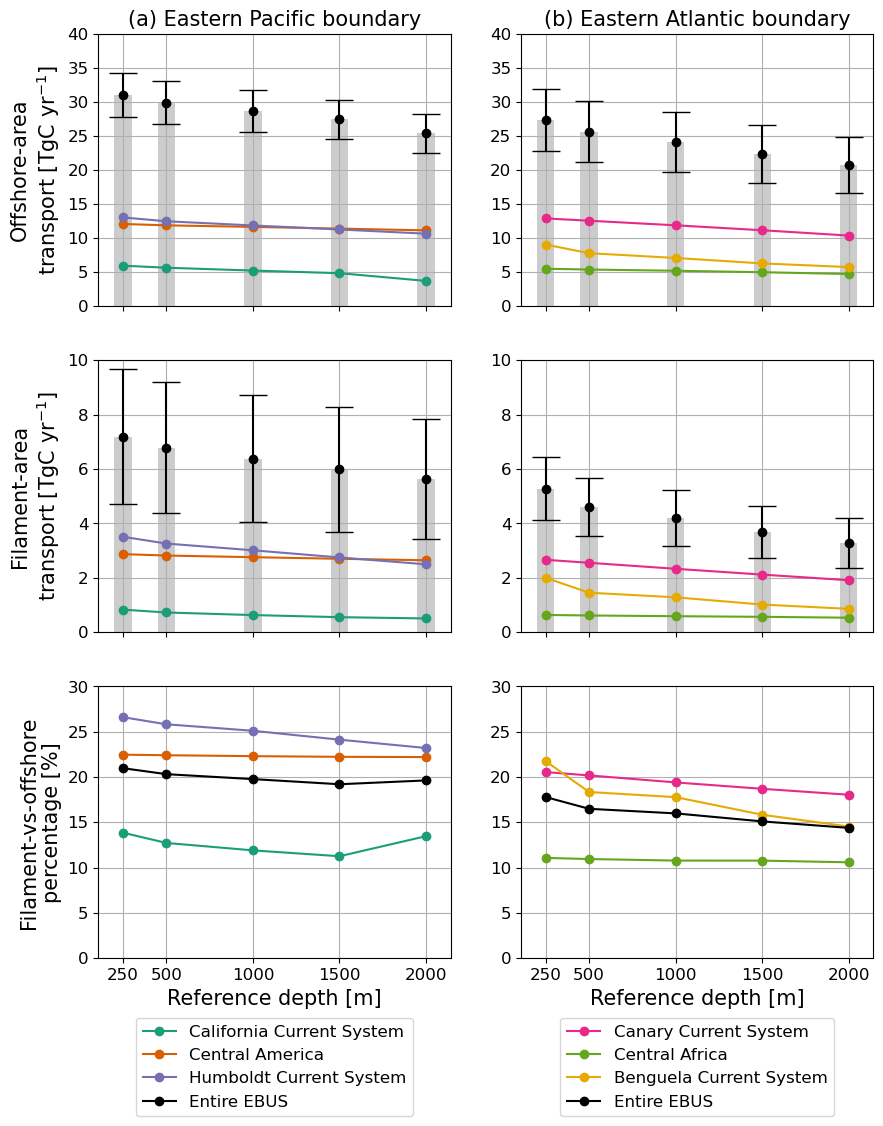

In [17]:
fig, ax = plt.subplots(ncols = 2, nrows = 3, figsize = [10,12], sharex = True)


big_plot(ax[0,0], offshelf_pac_transport, '(a) Eastern Pacific boundary', legend = False)
big_plot(ax[0,1], offshelf_atl_transport, '(b) Eastern Atlantic boundary', legend = False)
ax[0,0].set_xlabel('')
ax[0,1].set_xlabel('')

ax[0,0].set_ylim([0, 40])
ax[0,0].set_ylabel('Offshore-area\n'
                   'transport [TgC yr$^{-1}$]', fontsize = 15)

ax[0,1].set_ylim([0, 40])


big_plot(ax[1,0], pac_transport, '', legend = False)
big_plot(ax[1,1], atl_transport, '', legend = False)

ax[1,0].set_ylim([0, 10])
ax[1,1].set_ylim([0, 10])
ax[1,0].set_ylabel('Filament-area\n'
                   'transport [TgC yr$^{-1}$]', fontsize = 15)
ax[1,0].set_xlabel('')
ax[1,1].set_xlabel('')

big_plot(ax[2,0], pac_percentages, '', mean_total = True, bbox_to_anchor=(0.5, -0.4), fontsize = 12)
big_plot(ax[2,1], atl_percentages, '', mean_total = True, bbox_to_anchor=(0.5, -0.4), fontsize = 12)

ax[2,0].set_ylim([0, 30])
ax[2,1].set_ylim([0, 30])

ax[2,0].set_ylabel('Filament-vs-offshore\n'
                   'percentage [%]', fontsize = 15)


plt.savefig('images/figure_3_transport_estimates.png', bbox_inches = 'tight')

In [22]:
from scipy.stats import pearsonr

def plot_seasonality(inner, region, box_idx, suppress_y_tick_label = False, suppress_x_tick_label = False, resample_time = '1D'):


    ax = fig.add_subplot(inner[0,0])
    timeseries = compute_carbon_per_region(box_idx, os.path.join(path, 'outputs',  'export_timeseries'))

    maxs, mins = compute_maxmins_pairs(timeseries)

    transport_resampled = (maxs - mins).resample(time = '1D').sum()
    
    transport_grouped = transport_resampled.groupby('time.year').apply(lambda x: x.groupby('time.month').sum())
    transport_daily = transport_grouped.sum(dim = 'year') / 21
    
    transport_stds = transport_grouped.std(dim = 'year')
    tr_upper = transport_daily + transport_stds
    tr_lower = transport_daily - transport_stds
    ax.grid(alpha = 0.5)
    ax.plot(transport_daily.month, transport_daily, color = 'green')
    ax.fill_between(transport_daily.month, tr_lower, tr_upper, color = 'green', alpha = 0.2)
    ax.set_title(region, fontsize = 15)
    ax.set_ylim([0, 1])
    ax.set_yticks([0, 0.5, 1])


    ax1 = fig.add_subplot(inner[1,0])
    ax1.grid(alpha = 0.5)

    shelf_ts = compute_carbon_per_region(box_idx, os.path.join(path, 'outputs',  'shelf_timeseries'))
    shelf_grouped = shelf_ts.groupby('time.year').apply(lambda x: x.groupby('time.month').sum())
    sh_means = shelf_grouped.sum(dim = 'year') / 21
    sh_stds = shelf_grouped.std(dim = 'year')

    sh_upper = sh_means + sh_stds
    sh_lower = sh_means - sh_stds

    corr, p = pearsonr(transport_grouped.values.flatten(), shelf_grouped.values.flatten())

    ax1.plot(sh_means.month, sh_means, color = 'red', zorder = -1, 
                    #label = f'r$^2$ = {corr:.2f}'
                    )
    ax1.fill_between(sh_means.month, sh_lower, sh_upper, color = 'red', alpha = 0.2, zorder = -1)
    ax1.set_yticks([0, 2.5, 5])
    ax1.set_ylim([0, 5])
    ax1.text(6, ax1.get_ylim()[1] * 0.8, f'r = {corr:.1f}', color = 'red', fontsize = 12, weight = 'bold' if p < 0.05 else 'normal')



    ax2 = fig.add_subplot(inner[2,0])
    ax2.grid(alpha = 0.5)

    num_events = ((maxs - mins).resample(time = 'D').sum().fillna(0) > 0)
    num_events_grouped = num_events.groupby('time.year').apply(lambda x: x.groupby('time.month').sum())
    mean_num_events = num_events_grouped.sum(dim = 'year') / 21
    mean_num_std = num_events_grouped.std(dim = 'year')

    mean_upper = mean_num_events + mean_num_std
    mean_lower = mean_num_events - mean_num_std

    corr, p = pearsonr(transport_grouped.values.flatten(), num_events_grouped.values.flatten())
    ls2 = ax2.plot(mean_num_events.month, mean_num_events, color = 'navy', zorder = -1,
                   
                    #label = f'r$^2$ = {corr:.2f}'
                    )
    ax2.fill_between(mean_num_events.month, mean_lower, mean_upper, color = 'navy', alpha = 0.2, zorder = -1)
    ax2.set_ylim([0, 15])
    ax2.set_yticks(np.arange(0, 20, 5))
    ax2.text(6, ax2.get_ylim()[1] * 0.8, f'r = {corr:.1f}', color = 'navy', fontsize = 12, weight = 'bold' if p < 0.05 else 'normal')

    if suppress_y_tick_label:
        ax.set_yticks(ax.get_yticks(), labels = [])
        ax1.set_yticks(ax1.get_yticks(), labels = [])
        ax2.set_yticks(ax2.get_yticks(), labels = [])
    else:
        ax.tick_params(axis='y', colors='green', labelsize = 12)
        ax1.tick_params(axis='y', colors='red', labelsize = 12)
        ax2.tick_params(axis='y', colors='navy', labelsize = 12)

    ax.set_xticks(np.arange(1,13), labels = [])
    ax1.set_xticks(np.arange(1,13), labels = [])
    
    if suppress_x_tick_label:
        ax2.set_xticks(np.arange(1,13), labels = [])
    else:
        ax2.set_xticks(np.arange(1,13), labels =  ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],
                       fontsize = 12, rotation = 90)

        



/tmp/ipykernel_255279/1353255263.py:33: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


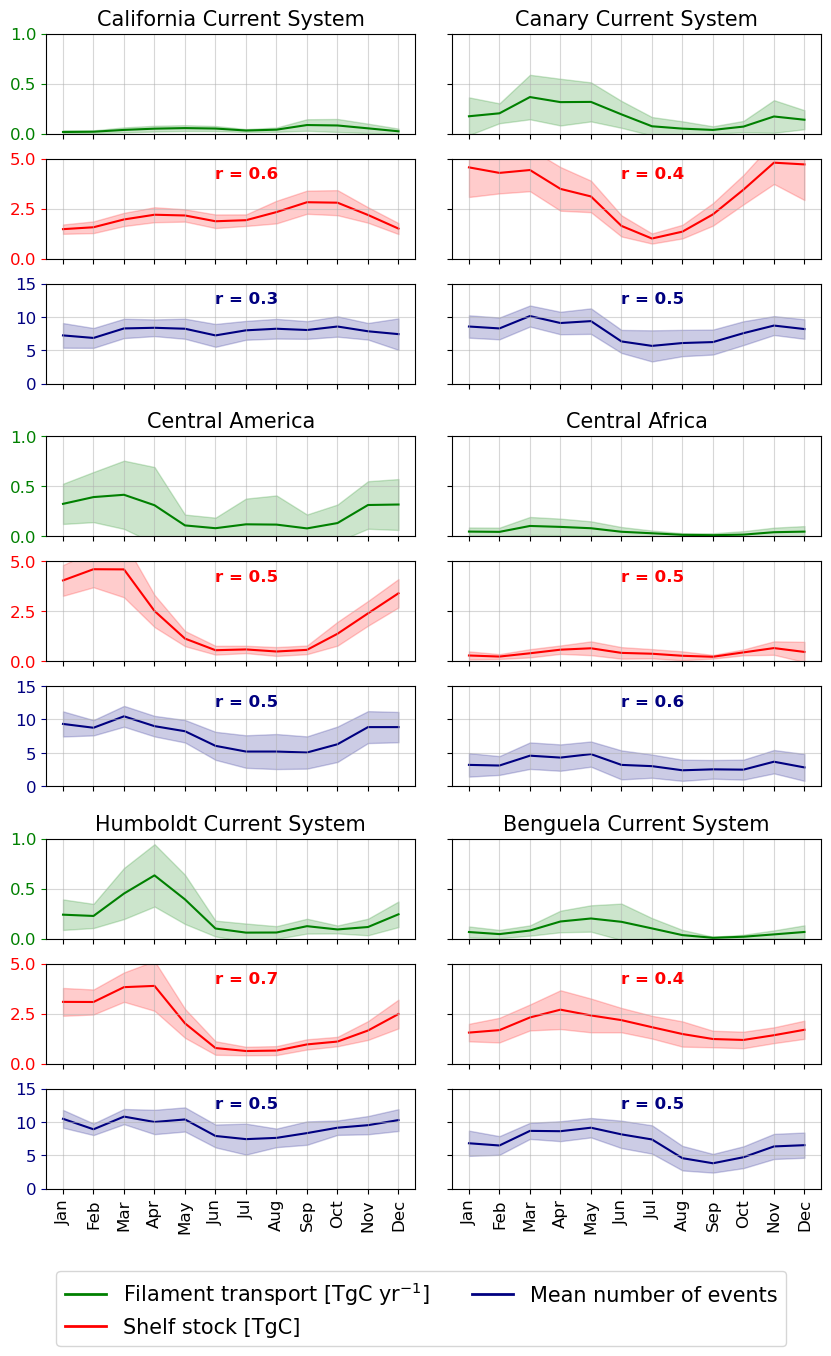

In [23]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=[10,15])
outer = gridspec.GridSpec(3, 2, wspace=0.1, hspace=0.15)

for j, ebu in enumerate(['pacific', 'atlantic']):

    regions = proc.read_region_input_files(os.path.join('../configs', f'{ebu}_regions.input'))
    boxes_groups = proc.obtain_boxes_grouping(regions)
    path = where_to_find_data(ebu)[1500]

    for i, (region, box_idx) in enumerate(zip(regions.keys(), boxes_groups)):
        inner = gridspec.GridSpecFromSubplotSpec(3, 1,
                        subplot_spec=outer[i, j], wspace=0.25, hspace=0.25)

        plot_seasonality(inner, region, box_idx, resample_time = '1D', suppress_y_tick_label= j == 1, suppress_x_tick_label= i < 2)

from matplotlib.lines import Line2D
from matplotlib.patches import Patch

legend_elements = [Line2D([0], [0], color='green', lw=2),
                   Line2D([0], [0], color='red', lw=2),
                   Line2D([0], [0], color='navy', lw=2),
                         ]


plt.figlegend(legend_elements, 
              ['Filament transport [TgC yr$^{-1}$]', 'Shelf stock [TgC]', 'Mean number of events'], 
              loc = 'center',
              bbox_to_anchor = (0.5,0.03), ncols = 2,
              fontsize = 15)
fig.tight_layout()
plt.savefig('images/figure_4_seasonality.png', bbox_inches = 'tight')

Text(0.5, 0, 'Filament transport [TgC yr$^{-1}$]')

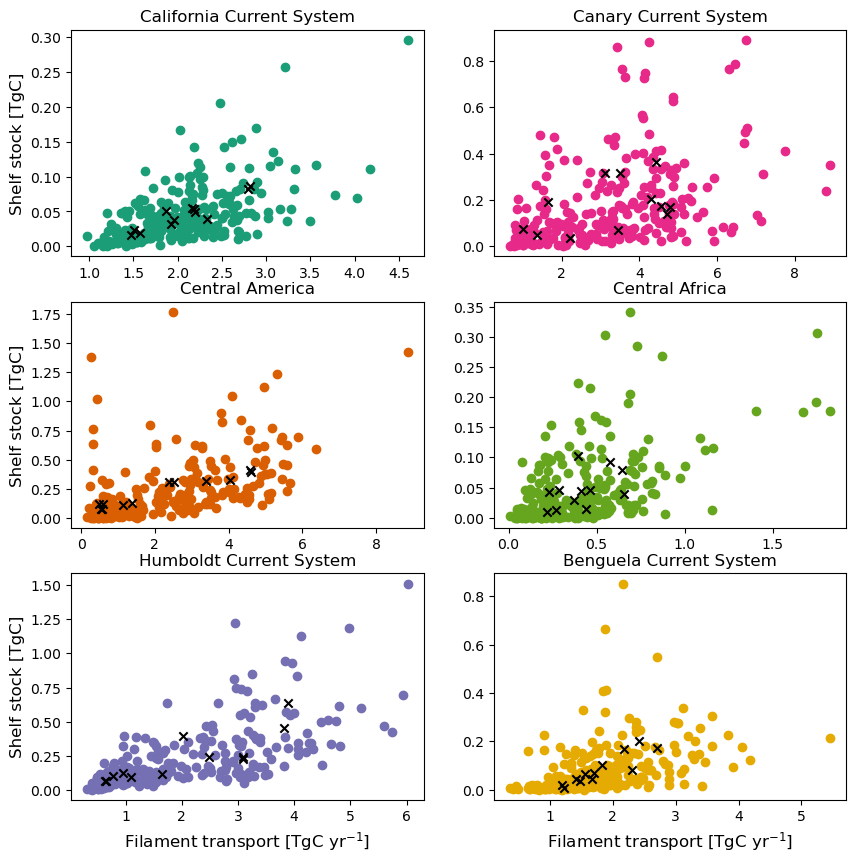

In [21]:

fig, ax = plt.subplots(nrows = 3, ncols = 2, figsize = [10,10])

for j, ebu in enumerate(['pacific', 'atlantic']):

    regions = proc.read_region_input_files(os.path.join('../configs', f'{ebu}_regions.input'))
    boxes_groups = proc.obtain_boxes_grouping(regions)
    path = where_to_find_data(ebu)[1500]

    for i, (region, box_idx) in enumerate(zip(regions.keys(), boxes_groups)):
        timeseries = compute_carbon_per_region(box_idx, os.path.join(path, 'outputs',  'export_timeseries'))

        maxs, mins = compute_maxmins_pairs(timeseries)

        transport_resampled = (maxs - mins).resample(time = '1D').sum()

        transport_grouped = transport_resampled.groupby('time.year').apply(lambda x: x.groupby('time.month').sum())#.sum(dim = 'year') / 21    
        transport_mean = transport_resampled.groupby('time.year').apply(lambda x: x.groupby('time.month').sum()).sum(dim = 'year') / 21    


        shelf_ts = compute_carbon_per_region(box_idx, os.path.join(path, 'outputs',  'shelf_timeseries'))
        shelf_grouped = shelf_ts.groupby('time.year').apply(lambda x: x.groupby('time.month').sum())#.sum(dim = 'year') / 21
        shelf_mean = shelf_ts.groupby('time.year').apply(lambda x: x.groupby('time.month').sum()).sum(dim = 'year') / 21

        ax[i,j].scatter(shelf_grouped.values.flatten(), transport_grouped.values.flatten(), c = colors[region])
        ax[i,j].scatter(shelf_mean.values.flatten(), transport_mean.values.flatten(), c = 'black', marker = 'x')

        ax[i,j].set_title(region)

        ax[i,0].set_ylabel('Shelf stock [TgC]', fontsize = 12)

ax[-1,0].set_xlabel('Filament transport [TgC yr$^{-1}$]', fontsize = 12)
ax[-1,1].set_xlabel('Filament transport [TgC yr$^{-1}$]', fontsize = 12)

        # num_events = ((maxs - mins).resample(time = 'D').sum().fillna(0) > 0)
        # num_events_grouped = num_events.groupby('time.year').apply(lambda x: x.groupby('time.month').sum())

Text(0.5, 0, 'Filament transport [TgC yr$^{-1}$]')

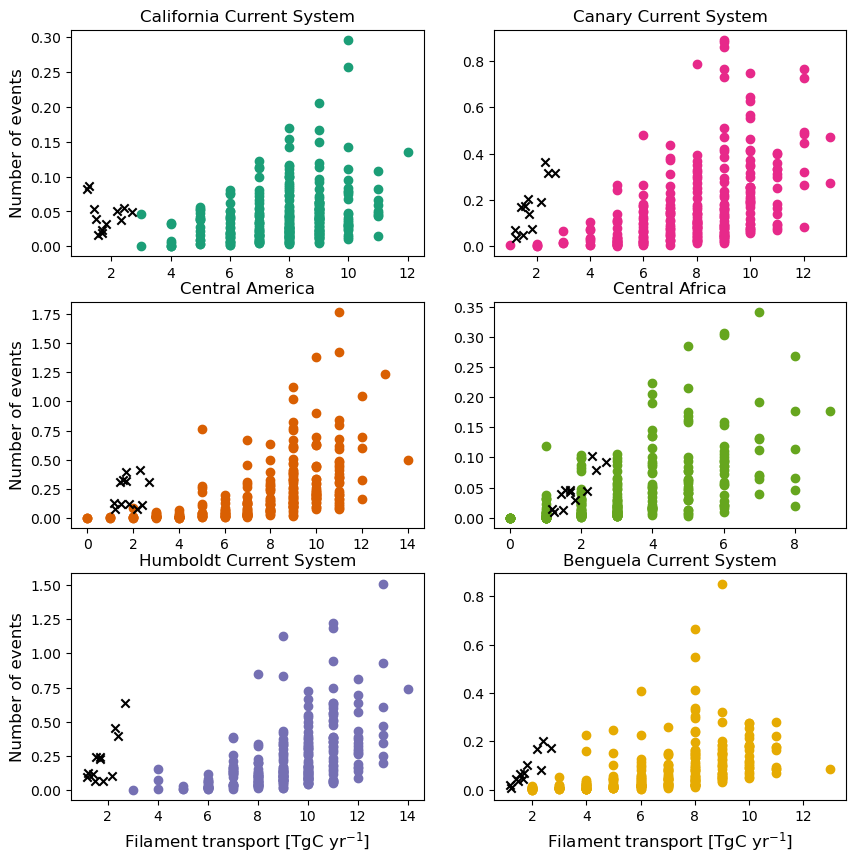

In [22]:

fig, ax = plt.subplots(nrows = 3, ncols = 2, figsize = [10,10])

for j, ebu in enumerate(['pacific', 'atlantic']):

    regions = proc.read_region_input_files(os.path.join('../configs', f'{ebu}_regions.input'))
    boxes_groups = proc.obtain_boxes_grouping(regions)
    path = where_to_find_data(ebu)[1500]

    for i, (region, box_idx) in enumerate(zip(regions.keys(), boxes_groups)):
        timeseries = compute_carbon_per_region(box_idx, os.path.join(path, 'outputs',  'export_timeseries'))

        maxs, mins = compute_maxmins_pairs(timeseries)

        transport_resampled = (maxs - mins).resample(time = '1D').sum()
        transport_grouped = transport_resampled.groupby('time.year').apply(lambda x: x.groupby('time.month').sum())
        transport_mean = transport_resampled.groupby('time.year').apply(lambda x: x.groupby('time.month').sum()).sum(dim = 'year') / 21    


        num_events = ((maxs - mins).resample(time = 'D').sum().fillna(0) > 0)
        num_events_grouped = num_events.groupby('time.year').apply(lambda x: x.groupby('time.month').sum())
        num_events_mean = shelf_ts.groupby('time.year').apply(lambda x: x.groupby('time.month').sum()).sum(dim = 'year') / 21

        ax[i,j].scatter(num_events_grouped.values.flatten(), transport_grouped.values.flatten(), c = colors[region])
        ax[i,j].scatter(num_events_mean.values.flatten(), transport_mean.values.flatten(), c = 'black', marker = 'x')
        ax[i,j].set_title(region)
        ax[i,0].set_ylabel('Number of events', fontsize = 12)

ax[-1,0].set_xlabel('Filament transport [TgC yr$^{-1}$]', fontsize = 12)
ax[-1,1].set_xlabel('Filament transport [TgC yr$^{-1}$]', fontsize = 12)